<a href="https://colab.research.google.com/github/FSMahi/People-Flow-Detection/blob/main/people_flow_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ultralytics opencv-python numpy matplotlib supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [7]:
import cv2
import numpy as np
from ultralytics import YOLO
import sys

# ==== CONFIG ====
SLOWDOWN_MS = 0
VIDEO_PATH = '/content/people-walking.mp4'
MODEL_PATH = '/content/yolov8n.pt'
OUTPUT_PATH = '/content/output_people_flow.mp4'

# Person class ID in COCO
PERSON_CLASS_ID = 0

# Line coordinates: [x1, y1], [x2, y2]
LINE_IN = np.array([[0, 218], [1967, 218]])      # Green line = IN
LINE_OUT = np.array([[0, 416], [1967, 416]])     # Red line = OUT


def ccw(A, B, C):
    """Check if points are in counter-clockwise order"""
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])


def intersect(A, B, C, D):
    """Return True if line AB and CD intersect"""
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)


def main():
    try:
        model = YOLO(MODEL_PATH)
    except Exception as e:
        print("[ERROR] Could not load YOLO model:", e)
        sys.exit(1)

    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print("Failed to open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Failed to read first frame.")
        return

    height, width = frame.shape[:2]
    RESIZE_DIMS = (960, 540)

    # Setup VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, RESIZE_DIMS)

    in_count = 0
    out_count = 0
    already_counted_in = set()
    already_counted_out = set()
    track_history = {}

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, RESIZE_DIMS)

        results = model.track(frame, persist=True, tracker="botsort.yaml", verbose=False)[0]
        boxes = results.boxes

        if boxes is None or boxes.xyxy is None:
            out.write(frame)
            continue

        class_ids = boxes.cls.cpu().numpy().astype(int)
        xyxy = boxes.xyxy.cpu().numpy()
        track_ids = boxes.id.cpu().numpy().astype(int) if boxes.id is not None else [None] * len(xyxy)

        person_indices = [i for i, cid in enumerate(class_ids) if cid == PERSON_CLASS_ID]

        # Draw IN and OUT lines
        cv2.line(frame, tuple(LINE_IN[0]), tuple(LINE_IN[1]), (0, 255, 0), 3)   # Green = IN
        cv2.line(frame, tuple(LINE_OUT[0]), tuple(LINE_OUT[1]), (0, 0, 255), 3) # Red = OUT

        for idx in person_indices:
            x1, y1, x2, y2 = map(int, xyxy[idx])
            track_id = track_ids[idx]

            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            center = (center_x, center_y)

            if track_id not in track_history:
                track_history[track_id] = []

            track_history[track_id].append(center)

            # Only consider last 2 positions
            if len(track_history[track_id]) > 2:
                track_history[track_id] = track_history[track_id][-2:]

            if len(track_history[track_id]) == 2:
                prev, curr = track_history[track_id]

                # IN line crossed (top to bottom)
                if (
                    intersect(prev, curr, LINE_IN[0], LINE_IN[1])
                    and (curr[1] > prev[1])  # downward movement
                    and track_id not in already_counted_in
                ):
                    in_count += 1
                    already_counted_in.add(track_id)

                # OUT line crossed (bottom to top)
                if (
                    intersect(prev, curr, LINE_OUT[0], LINE_OUT[1])
                    and (curr[1] < prev[1])  # upward movement
                    and track_id not in already_counted_out
                ):
                    out_count += 1
                    already_counted_out.add(track_id)

            # === Draw bounding box based on crossing status ===
            if track_id in already_counted_in:
                box_color = (0, 255, 0)  # Green
            elif track_id in already_counted_out:
                box_color = (0, 0, 255)  # Red
            else:
                box_color = (255, 255, 255)  # White

            # Draw box, center dot, and ID
            cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
            cv2.circle(frame, center, 5, box_color, -1)
            cv2.putText(frame, f'ID {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

        # Display counters
        cv2.putText(frame, f'IN: {in_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
        cv2.putText(frame, f'OUT: {out_count}', (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

        out.write(frame)

    cap.release()
    out.release()
    print(f"[✅ DONE] Output saved to: {OUTPUT_PATH}")


if __name__ == '__main__':
    main()


[✅ DONE] Output saved to: /content/output_people_flow.mp4


In [8]:
#import cv2
#import numpy as np
#from ultralytics import YOLO
#import sys

# ==== CONFIG ====
#SLOWDOWN_MS = 0
#VIDEO_PATH = '/content/people-walking.mp4'
#MODEL_PATH = '/content/yolov8n.pt'
#OUTPUT_PATH = '/content/output_people_flow.mp4'

# Person class ID in COCO
#PERSON_CLASS_ID = 0

# Line coordinates: [x1, y1], [x2, y2]
#LINE_IN = np.array([[10, 318], [1967, 302]])      # Green line = IN
#LINE_OUT = np.array([[10, 616], [1967, 604]])     # Red line = OUT


#def ccw(A, B, C):
 #   """Check if points are in counter-clockwise order"""
  #  return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

#def intersect(A, B, C, D):
    #"""Return True if line AB and CD intersect"""
   # return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)


#def main():
    #try:
   #     model = YOLO(MODEL_PATH)
  #  except Exception as e:
 #       print("[ERROR] Could not load YOLO model:", e)
 #       sys.exit(1)

#    cap = cv2.VideoCapture(VIDEO_PATH)
    #if not cap.isOpened():
      #  print("Failed to open video.")
     #   return

    #ret, frame = cap.read()
    #if not ret:
      #  print("Failed to read first frame.")
     #   return

    #height, width = frame.shape[:2]
    #RESIZE_DIMS = (960, 540)

    # Setup VideoWriter
    #fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #fps = cap.get(cv2.CAP_PROP_FPS)
    #out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, RESIZE_DIMS)

    #in_count = 0
    #out_count = 0
    #already_counted_in = set()
    #already_counted_out = set()
    #track_history = {}

    #cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    #while True:
        #ret, frame = cap.read()
        #if not ret:
         #   break

        #frame = cv2.resize(frame, RESIZE_DIMS)

        #results = model.track(frame, persist=True, tracker="botsort.yaml", verbose=False)[0]
        #boxes = results.boxes

        #if boxes is None or boxes.xyxy is None:
          #  out.write(frame)
         #   continue

        #class_ids = boxes.cls.cpu().numpy().astype(int)
        #xyxy = boxes.xyxy.cpu().numpy()
        #track_ids = boxes.id.cpu().numpy().astype(int) if boxes.id is not None else [None] * len(xyxy)

        #person_indices = [i for i, cid in enumerate(class_ids) if cid == PERSON_CLASS_ID]

        # Draw IN and OUT lines
        #cv2.line(frame, tuple(LINE_IN[0]), tuple(LINE_IN[1]), (0, 255, 0), 3)   # Green = IN
        #cv2.line(frame, tuple(LINE_OUT[0]), tuple(LINE_OUT[1]), (0, 0, 255), 3) # Red = OUT

        #for idx in person_indices:
            #x1, y1, x2, y2 = map(int, xyxy[idx])
            #track_id = track_ids[idx]

            #center_x = (x1 + x2) // 2
            #center_y = (y1 + y2) // 2
            #center = (center_x, center_y)

            #if track_id not in track_history:
             #   track_history[track_id] = []

            #track_history[track_id].append(center)

            # Only consider last 2 positions
            #if len(track_history[track_id]) > 2:
             #   track_history[track_id] = track_history[track_id][-2:]

            #if len(track_history[track_id]) == 2:
                #prev, curr = track_history[track_id]

                # IN line crossed (top to bottom)
                #if (
                  #  intersect(prev, curr, LINE_IN[0], LINE_IN[1])
                 #   and (curr[1] > prev[1])  # downward movement
                #    and track_id not in already_counted_in
               # ):
                  #  in_count += 1
                 #   already_counted_in.add(track_id)

                # OUT line crossed (bottom to top)
                #if (
                #    intersect(prev, curr, LINE_OUT[0], LINE_OUT[1])
               #     and (curr[1] < prev[1])  # upward movement
              #      and track_id not in already_counted_out
             #   ):
            #        out_count += 1
           #         already_counted_out.add(track_id)

            # Draw bounding box and ID
          #  cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
         #   cv2.circle(frame, center, 5, (0, 255, 0), -1)
        #    cv2.putText(frame, f'ID {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Display counters
       # cv2.putText(frame, f'IN: {in_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
      #  cv2.putText(frame, f'OUT: {out_count}', (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

     #   out.write(frame)

    #cap.release()
   # out.release()
  #  print(f"[✅ DONE] Output saved to: {OUTPUT_PATH}")


#if __name__ == '__main__':
 #   main()


# Heatmap Generation

In [ ]:
!pip install -q ultralytics supervision lap

In [ ]:
!pip uninstall -y supervision
!pip install git+https://github.com/roboflow/supervision.git


Found existing installation: supervision 0.27.0rc1
Uninstalling supervision-0.27.0rc1:
  Successfully uninstalled supervision-0.27.0rc1
  Cloning https://github.com/roboflow/supervision.git to /tmp/pip-req-build-vbbobsns
  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/supervision.git /tmp/pip-req-build-vbbobsns
  Resolved https://github.com/roboflow/supervision.git to commit 005cdbd37abec947301ed005d34d07a4c97f80bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for supervision: filename=supervision-0.27.0rc1-py3-none-any.whl size=210856 sha256=b96d7fd2f188d428002d91011006e8d63f7a749ba5bfe332fb5d90cf2217d3e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-yg8a8pks/wheels/33/af/71/668cfbe80a3aea36380e7d62d7f91f925075cfad3e4c573288
Successfully built supervision


# Pedestrian Traffic Heatmap Generation


video 1/1 (frame 1/341) /content/people-walking.mp4: 384x640 37 persons, 2 birds, 198.3ms
video 1/1 (frame 2/341) /content/people-walking.mp4: 384x640 36 persons, 2 birds, 159.9ms
video 1/1 (frame 3/341) /content/people-walking.mp4: 384x640 35 persons, 3 birds, 164.8ms
video 1/1 (frame 4/341) /content/people-walking.mp4: 384x640 35 persons, 3 birds, 187.2ms
video 1/1 (frame 5/341) /content/people-walking.mp4: 384x640 34 persons, 2 birds, 154.1ms
video 1/1 (frame 6/341) /content/people-walking.mp4: 384x640 37 persons, 2 birds, 158.0ms
video 1/1 (frame 7/341) /content/people-walking.mp4: 384x640 36 persons, 2 birds, 160.6ms
video 1/1 (frame 8/341) /content/people-walking.mp4: 384x640 37 persons, 2 birds, 157.3ms
video 1/1 (frame 9/341) /content/people-walking.mp4: 384x640 38 persons, 1 bird, 172.9ms
video 1/1 (frame 10/341) /content/people-walking.mp4: 384x640 38 persons, 2 birds, 160.8ms
video 1/1 (frame 11/341) /content/people-walking.mp4: 384x640 39 persons, 1 bird, 160.8ms
video 1/1

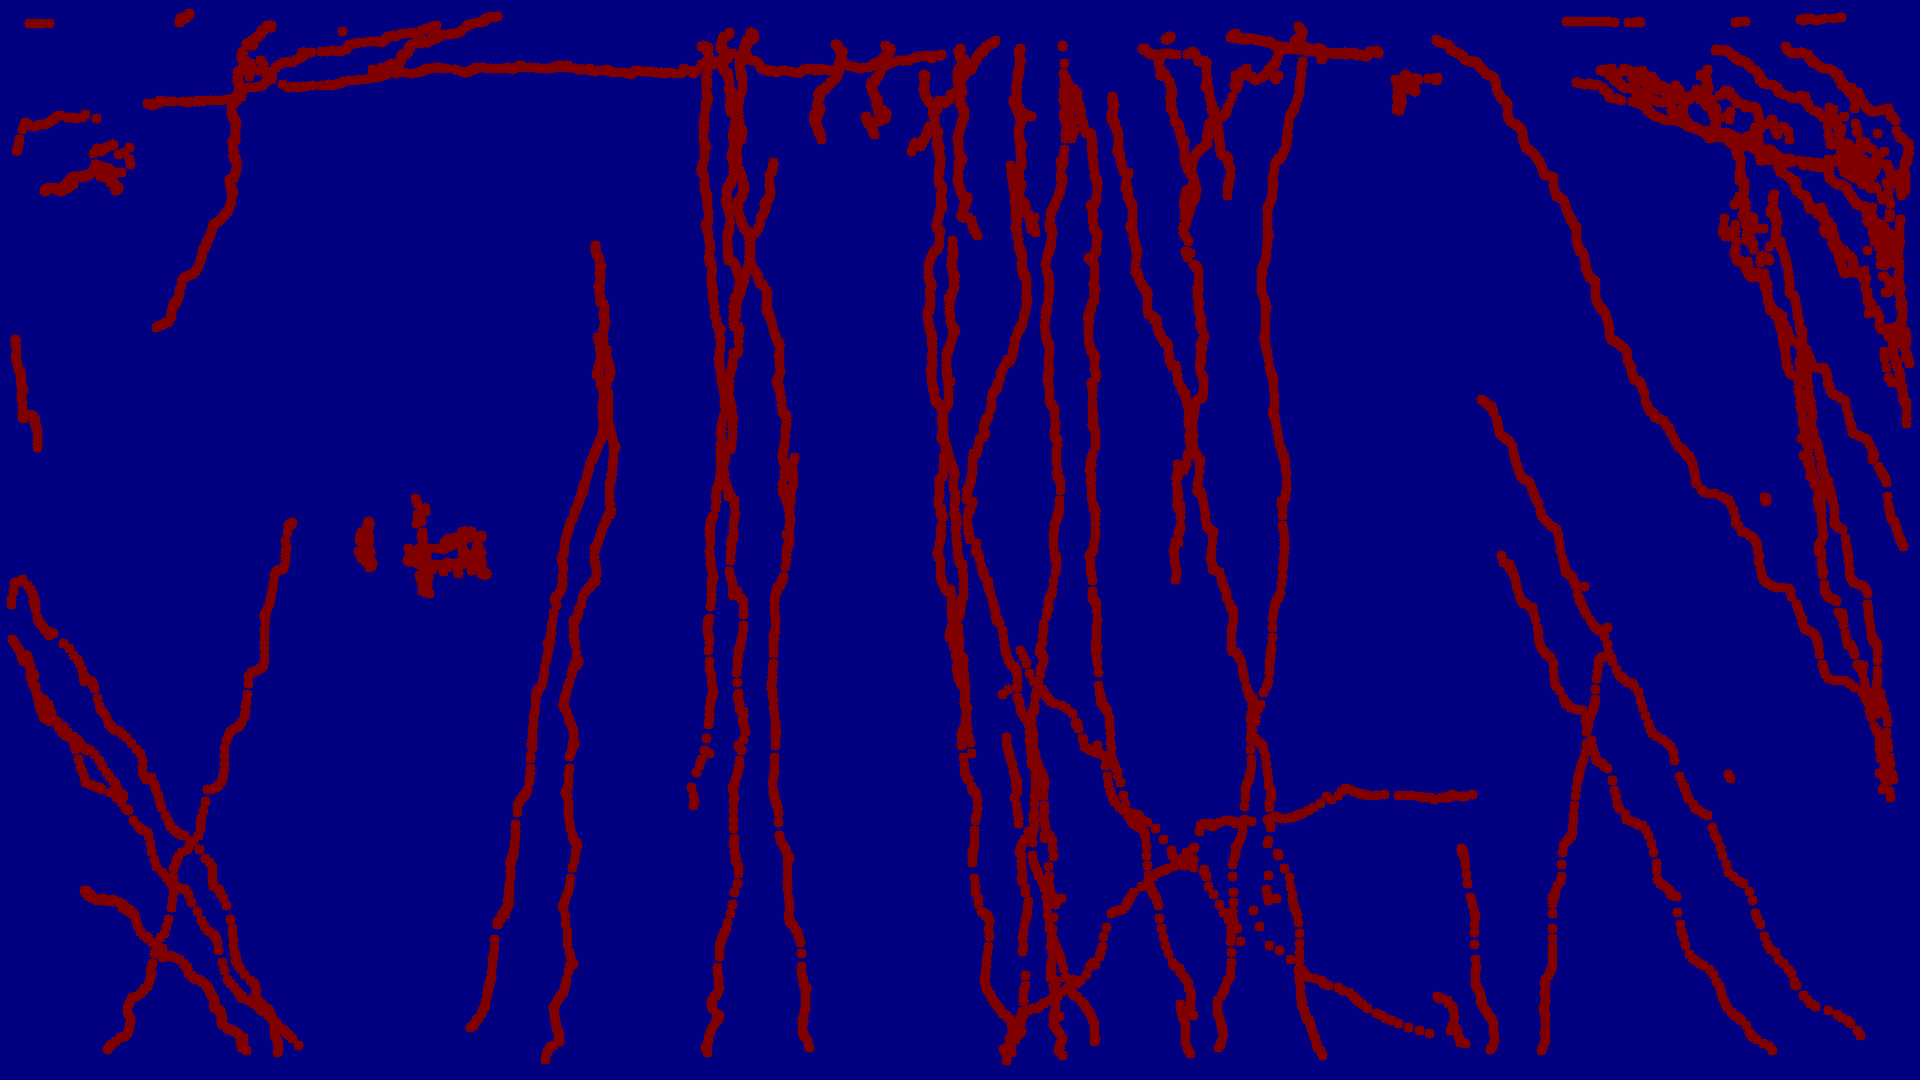

📌 Overlay with last frame:


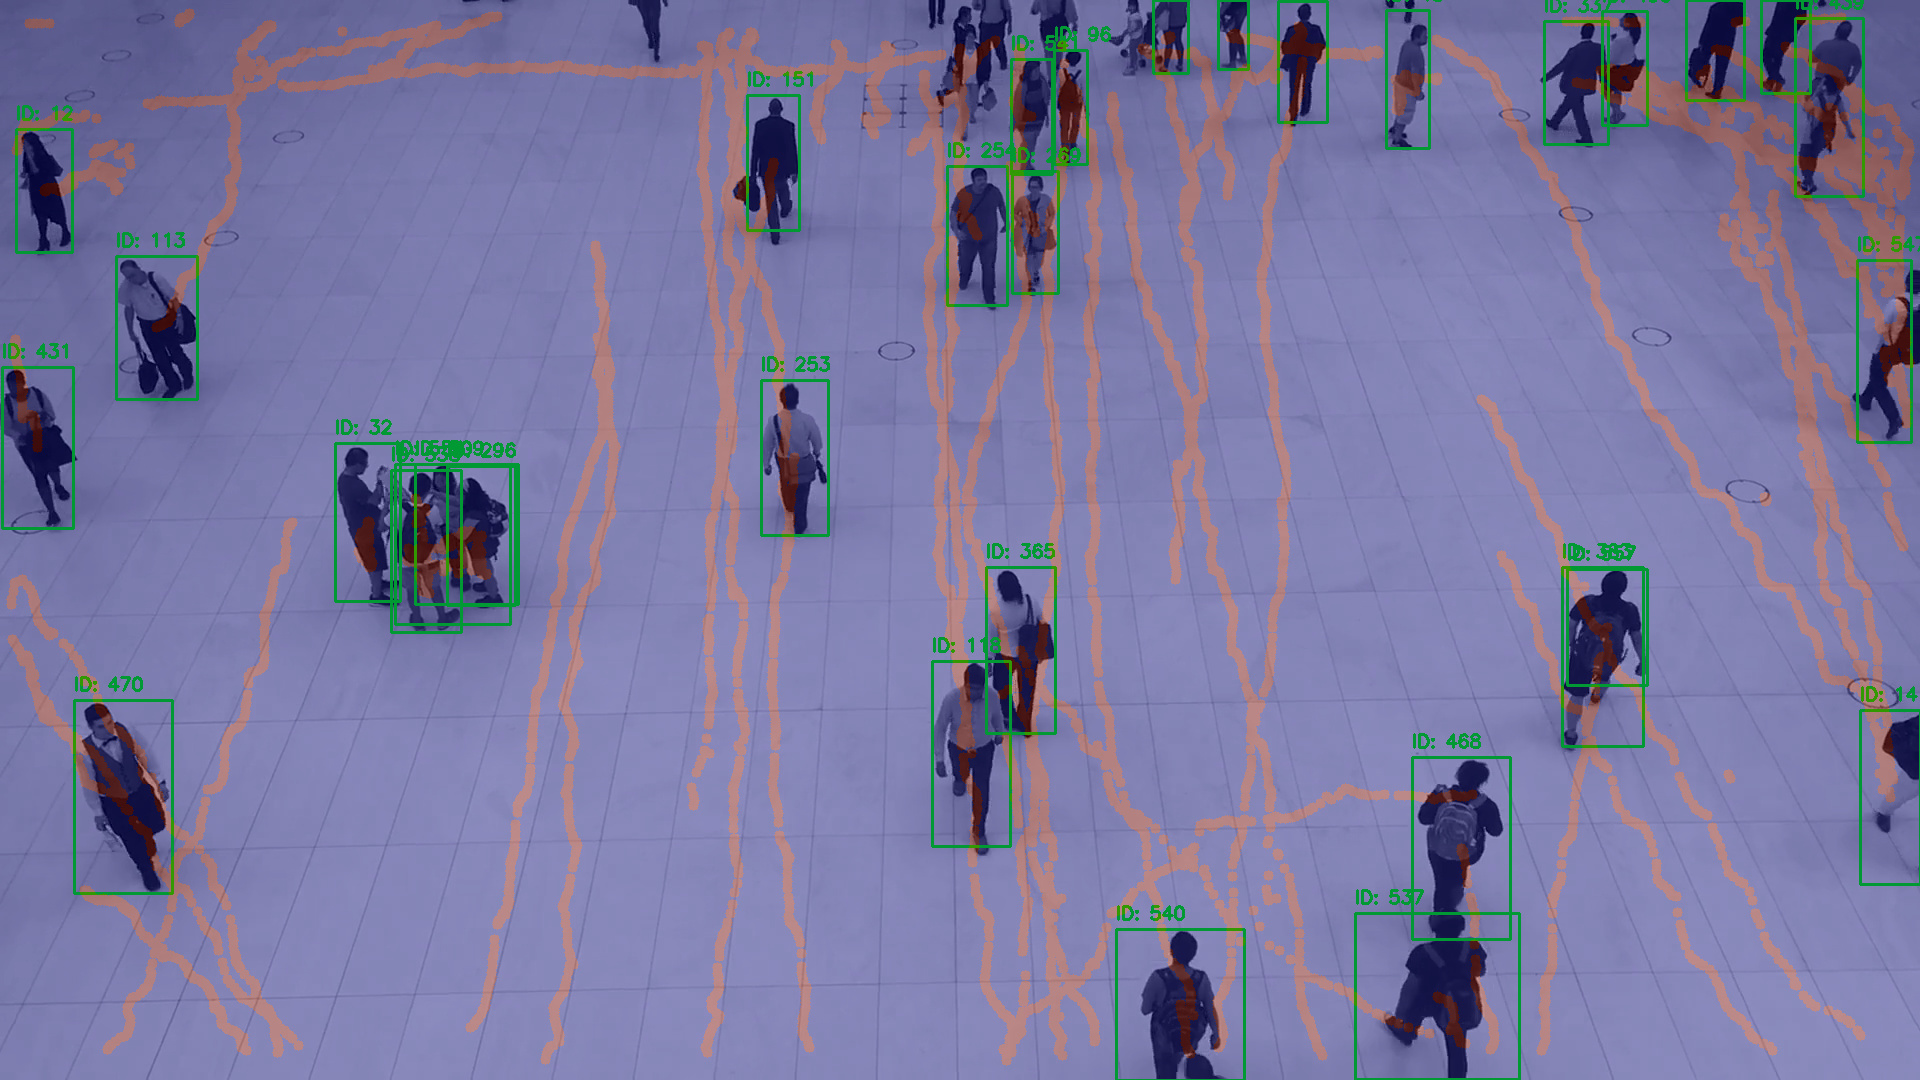

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
from google.colab.patches import cv2_imshow

VIDEO_PATH = '/content/people-walking.mp4'
MODEL_PATH = '/content/yolov8n.pt'

def main():
    # Load model with tracking
    model = YOLO(MODEL_PATH)

    # Enable tracker
    model.predict(source=VIDEO_PATH, stream=True, tracker="bytetrack.yaml")

    cap = cv2.VideoCapture(VIDEO_PATH)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create empty heatmap
    heatmap = np.zeros((height, width), dtype=np.float32)

    frame_idx = 0
    for result in model.track(source=VIDEO_PATH, stream=True, tracker="bytetrack.yaml"):
        frame = result.orig_img.copy()

        if result.boxes is None:
            continue

        boxes = result.boxes.xyxy.cpu().numpy()       # x1, y1, x2, y2
        ids = result.boxes.id.cpu().numpy().astype(int) if result.boxes.id is not None else None

        for box, track_id in zip(boxes, ids):
            x1, y1, x2, y2 = box.astype(int)
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

            # Accumulate center on heatmap
            cv2.circle(heatmap, (cx, cy), radius=5, color=1, thickness=-1)

            # Draw bounding box with ID
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        frame_idx += 1
        if frame_idx % 50 == 0:
            print(f'Processed {frame_idx} frames')

    cap.release()

    # Normalize and colorize heatmap
    heatmap_img = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_img = np.uint8(heatmap_img)
    heatmap_color = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)

    # Blend heatmap over last frame (optional)
    overlay = cv2.addWeighted(frame, 0.6, heatmap_color, 0.4, 0)

    # Save results
    cv2.imwrite('/content/heatmap_only.jpg', heatmap_color)
    cv2.imwrite('/content/heatmap_overlay.jpg', overlay)
    print("✅ Saved: heatmap_only.jpg")
    print("✅ Saved: heatmap_overlay.jpg")

    # Display in Colab
    print("📌 Heatmap:")
    cv2_imshow(heatmap_color)
    print("📌 Overlay with last frame:")
    cv2_imshow(overlay)

if __name__ == '__main__':
    main()

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
from google.colab.patches import cv2_imshow

VIDEO_PATH = '/content/people-walking.mp4'
MODEL_PATH = '/content/yolov8n.pt'
OUTPUT_VIDEO_PATH = '/content/heatmap_video.mp4'


def main():
    # Load model with tracking
    model = YOLO(MODEL_PATH)

    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print('Failed to open video file.')
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create empty heatmap
    heatmap = np.zeros((height, width), dtype=np.float32)

    # Setup VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

    frame_idx = 0
    # Process video frame by frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Run tracking on the current frame
        results = model.track(frame, persist=True, tracker="bytetrack.yaml", verbose=False)[0]

        if results.boxes is not None:
            boxes = results.boxes.xyxy.cpu().numpy()       # x1, y1, x2, y2
            ids = results.boxes.id.cpu().numpy().astype(int) if results.boxes.id is not None else None

            for box, track_id in zip(boxes, ids):
                x1, y1, x2, y2 = box.astype(int)
                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

                # Accumulate center on heatmap
                cv2.circle(heatmap, (cx, cy), radius=5, color=1, thickness=-1)

                # Draw bounding box with ID on the frame
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Normalize and colorize heatmap for the current frame
        heatmap_img_frame = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
        heatmap_img_frame = np.uint8(heatmap_img_frame)
        heatmap_color_frame = cv2.applyColorMap(heatmap_img_frame, cv2.COLORMAP_JET)

        # Blend heatmap over the current frame
        overlay_frame = cv2.addWeighted(frame, 0.6, heatmap_color_frame, 0.4, 0)

        # Write the overlaid frame to the output video
        out.write(overlay_frame)

        frame_idx += 1
        if frame_idx % 50 == 0:
            print(f'Processed {frame_idx} frames')

    cap.release()
    out.release()
    print(f"✅ Saved video: {OUTPUT_VIDEO_PATH}")


if __name__ == '__main__':
    main()

Processed 50 frames
Processed 100 frames
Processed 150 frames
Processed 200 frames
Processed 250 frames
Processed 300 frames
✅ Saved video: /content/heatmap_video.mp4
